## **Projet - Réalisez un traitement dans un environnement Big Data sur le Cloud**

#### **Contexte**
- **Start-up** : "Fruits!"
- **Objectif** : Développement d’une application mobile permettant aux utilisateurs de prendre en photo un fruit et d’obtenir des informations à son sujet, sensibilisant ainsi à la biodiversité.
- **Point de départ** : Un notebook créé par un alternant, nommé `P8_Notebook_Linux_EMR_PySpark_V1.0.ipynb`. Ce notebook propose une première approche de traitement des données dans un environnement Big Data AWS EMR, incluant un jeu de données composé d’images de fruits avec leurs labels associés.  
- **Données** : Images de fruits et labels associés.  

#### **Mes missions**
1. **Compléter la chaîne de traitement** développée par l’alternant, en y intégrant :  
   - Une étape de réduction de dimension via **PCA** (Principal Component Analysis) en PySpark.  
   - Une diffusion des poids d’un modèle TensorFlow sur les clusters (broadcast des “weights”).  

2. **Respect des contraintes du projet** :  
   - Tenir compte de l’augmentation rapide du volume de données après la livraison du projet.  
   - Implémenter un traitement adapté à une architecture Big Data, en choisissant entre **AWS EMR** et **Databricks**.  
   - Respecter les normes RGPD, en s’assurant que les traitements et le stockage des données se font sur des serveurs situés sur le territoire européen.

3. **Limiter les coûts** :  
   - Utiliser un serveur local pour le développement et réserver l’utilisation de l’environnement EMR/Cloud aux tests et démonstrations.  

4. **Documentation et pédagogie** :  
   - Fournir un notebook bien documenté et un script PySpark clair, détaillant pas à pas le processus de traitement des données.  
   - Préparer un support de présentation expliquant les choix technologiques et les étapes de traitement.

#### **Livrables**
1. **Notebook PySpark** :  
   - Contenant le script PySpark complet, incluant le prétraitement et la réduction de dimension via PCA.  
   - Hébergé sur le Cloud pour permettre une exécution reproductible.  

2. **Données transformées** :  
   - Les images du jeu de données initial et la matrice issue de la réduction de dimension (CSV ou autre format).  
   - Stockées dans un espace Cloud conforme aux normes RGPD.  

3. **Support de présentation** :  
   - Présentant les briques d’architecture choisies et leur rôle.  
   - Décrivant la mise en œuvre de l’environnement Big Data (EMR ou Databricks).  
   - Expliquant les étapes de la chaîne de traitement PySpark.

#### **Référentiel d’évaluation**
1. **Identifier les outils Cloud pour un environnement Big Data conforme aux normes RGPD :**
   - CE1 : Identifier les briques nécessaires pour l’architecture Big Data.  
   - CE2 : Sélectionner les outils conformes aux normes RGPD.  

2. **Manipuler les données dans un environnement Big Data :**
   - CE1 : Charger et transformer les données dans un espace de stockage Cloud conforme au RGPD.  
   - CE2 : Exécuter les scripts avec des machines Cloud.  
   - CE3 : Enregistrer les sorties dans un espace de stockage Cloud.  

3. **Réaliser des calculs distribués avec PySpark :**
   - CE1 : Identifier les traitements critiques pour le passage à l’échelle.  
   - CE2 : Assurer la conformité RGPD pour les traitements et le stockage.  
   - CE3 : Développer des scripts PySpark pour les calculs distribués.  
   - CE4 : Exécuter toute la chaîne de traitement dans le Cloud.  


#### **Prises de notes**
- **Pas d’entraînement du modèle** :  
  - Approche basée sur le **transfert learning**.  
  - Récupération de l’avant-dernière couche du modèle.  
  - Utilisation du modèle **MobileNetV2** :  
    - Rapide et efficace.  
    - Dimensionnalité réduite de l’avant-dernière couche (1,1,1280).  

- **Jeu de données** :  
  - **Source** : fruits-360_dataset.  
  - **Statistiques** :  
    - Nombre total d’images : **94,110**.  
    - Nombre d’images pour l’entraînement : **70,491**.  
    - Nombre d’images pour les tests : **23,619**.  
    - Nombre de classes : **141**.  
    - Taille des images : **100x100** pixels.  

### **Exécution locale du script PySpark** :  
  - Le script doit être exécuté localement avant d’être déployé dans l’environnement Cloud.  
  - Interface de suivi des tâches Spark accessible via : [http://localhost:4040](http://localhost:4040) (pour arrêter l’interface, exécuter spark.stop).

In [2]:
# Importation des modules nécessaires
import logging  # Module pour gérer les messages de log (journalisation)
import sys      # Module pour interagir avec l'interpréteur Python
import os       # Module pour interagir avec le système d'exploitation

# Désactive tous les messages de log, quel que soit leur niveau
# `sys.maxsize` définit une valeur très élevée, bloquant ainsi tous les niveaux de logs.
logging.disable(sys.maxsize)

# Réduit les messages affichés par TensorFlow
# `TF_CPP_MIN_LOG_LEVEL` contrôle le niveau des messages TensorFlow :
# 0 = tous les messages, 1 = pas de 'INFO', 2 = pas de 'WARNING', 3 = pas de 'ERROR'.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### **Installation de Spark :** suivez les étapes décrites dans ce lien : [How to install Apache Spark on Ubuntu/Debian](https://computingforgeeks.com/how-to-install-apache-spark-on-ubuntu-debian/)


### **Installation des packages :** installez toutes ces librairies avec pip :  
`!pip install pandas pillow tensorflow pyspark pyarrow`

### **Import des librairies:**

In [3]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# Importation de fonctions spécifiques de PySpark pour la manipulation des données distribuées
from pyspark.sql.functions import (
    col,               # Pour sélectionner ou manipuler les colonnes d'un DataFrame PySpark
    pandas_udf,        # Pour écrire des UDF (User-Defined Functions) avec pandas
    PandasUDFType,     # Pour spécifier le type d'une pandas_udf
    element_at,        # Pour accéder à un élément dans une colonne de type array
    split              # Pour diviser une chaîne de caractères dans une colonne
)

# Importation de la classe SparkSession pour créer et gérer une session Spark
from pyspark.sql import SparkSession

E0000 00:00:1731921030.726087   19540 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731921030.733045   19540 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### **Définition des PATH:**
Pour préparer les données, les **23,619** images du dossier **Test** sont déplacées vers **/data/Test1**, où elles seront traitées.  
Un dossier **/data/Result** qui contiendra les résultats après traitement.

- **Chemin pour charger les images** :  
  `input_path = "/data/Test1"`  
  Ce dossier contient les images prêtes à être traitées.  

- **Chemin pour enregistrer les résultats** :  
  `output_path = "/data/Result"`  
  Ce dossier est utilisé pour stocker les fichiers générés.

In [4]:
# Obtenir le chemin de travail actuel (répertoire courant)
PATH = os.getcwd()

# Définir le chemin vers le dossier contenant les données à traiter
PATH_Data = PATH + '/data/Test1'

# Définir le chemin vers le dossier où les résultats seront enregistrés
PATH_Result = PATH + '/data/Results'

# Afficher les chemins définis pour vérification
print('PATH:        ' + PATH + '\n' +  # Chemin du répertoire courant
      'PATH_Data:   ' + PATH_Data + '\n' +  # Chemin du dossier des données
      'PATH_Result: ' + PATH_Result)  # Chemin du dossier des résultats

PATH:        /home/abbasbil/Openclassrooms/Projet_8
PATH_Data:   /home/abbasbil/Openclassrooms/Projet_8/data/Test1
PATH_Result: /home/abbasbil/Openclassrooms/Projet_8/data/Results


### **Création de la SparkSession :**

Par défaut, Spark alloue **1 Go** de mémoire au driver et **1 Go** à l’exécuteur. Étant donné que mon PC dispose de **31 Go de mémoire libre**, je vais augmenter ces valeurs pour améliorer les performances. J'allouerai **4 Go** de mémoire au driver et **8 Go** à l’exécuteur. Cela permettra à Spark de gérer plus efficacement les traitements lourds.

In [5]:
# Configuration de la SparkSession
spark = (SparkSession
         .builder
         .appName('P8')                          # Nom de l'application
         .master('local')                        # Mode d'exécution local
         .config("spark.sql.parquet.writeLegacyFormat", 'true')  # Compatibilité avec les anciens fichiers Parquet
         .config("spark.driver.memory", "4g")    # Alloue 4 Go au driver
         .config("spark.executor.memory", "8g")  # Alloue 8 Go aux exécuteurs
         .getOrCreate()
)

24/11/18 10:10:36 WARN Utils: Your hostname, ABBASBILL resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/11/18 10:10:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/18 10:10:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### **Création de SparkContext:** 
Le **SparkContext** est automatiquement inclus lors de la création d'une SparkSession. Pour accéder au **SparkContext** par défaut, il suffit d'utiliser l'attribut ***.sparkContext*** de la SparkSession.

In [6]:
# Accéder au SparkContext à partir de la SparkSession
sc = spark.sparkContext

### **Affichage des informations de la SparkSession en cours d'exécution :**
Cette commande permet d'afficher les informations relatives à la SparkSession active.

In [7]:
# Affichage des informations de la SparkSession
spark

### **Chargement des données:**

- Chargement des images au format binaire
- On spécifie que seuls les fichiers ayant l'extension **jpg** doivent être chargés.  
- On indique également de charger les objets présents dans tous les sous-dossiers du répertoire source.  

In [8]:
# Chargement des images au format binaire avec Spark
# - format("binaryFile") : Charge les fichiers en format binaire, utile pour manipuler des fichiers non structurés (images, audio, etc.).
# - option("pathGlobFilter", "*.jpg") : Limite le chargement aux fichiers avec l'extension ".jpg" uniquement.
# - option("recursiveFileLookup", "true") : Permet de parcourir tous les sous-dossiers du répertoire donné pour trouver les fichiers.
# - load(PATH_Data) : Spécifie le chemin (PATH_Data) depuis lequel les fichiers seront chargés.

images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

In [9]:
print(images.printSchema())
print(images.show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)

None
+---------------------------------------------------------------------------------+-----------------------+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Nous affichons les premières informations des images avec :  
- Le chemin complet de chaque image (**path**)  
- La date et l'heure de la dernière modification (**modificationTime**)  
- Le contenu de l'image encodé en hexadécimal (**content**)  

Pour les traitements suivants, je conserve uniquement le chemin de l'image (**path**) et ajoute une colonne **label** correspondant à chaque image.

In [10]:
from pyspark.sql.functions import rand

images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
random_images = images.orderBy(rand())
print(random_images.printSchema())
print(random_images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None


+----------------------------------------------------------------------------------+--------------+
|path                                                                              |label         |
+----------------------------------------------------------------------------------+--------------+
|file:/home/abbasbil/Openclassrooms/Projet_8/data/Test1/Walnut 1/r2_104_100.jpg    |Walnut 1      |
|file:/home/abbasbil/Openclassrooms/Projet_8/data/Test1/Pear Forelle 1/r_10_100.jpg|Pear Forelle 1|
|file:/home/abbasbil/Openclassrooms/Projet_8/data/Test1/Pear 2/r2_93_100.jpg       |Pear 2        |
|file:/home/abbasbil/Openclassrooms/Projet_8/data/Test1/Pepper Red 1/294_100.jpg   |Pepper Red 1  |
|file:/home/abbasbil/Openclassrooms/Projet_8/data/Test1/Huckleberry 1/268_100.jpg  |Huckleberry 1 |
+----------------------------------------------------------------------------------+--------------+
only showing top 5 rows

None


### **Préparation du modèle MobileNetV2 (préentraîné sur ImageNet) :**

Pour plus de détails, vous pouvez consulter cet article : [MobileNetV2 - Lightweight Model for Image Classification](https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c)

Au lieu d'entraîner un nouveau modèle, j'utiliserai le **transfert learning** pour extraire les **features** (caractéristiques) des images. Pour cela, j'ai choisi le modèle **MobileNetV2**. Je n'utiliserai pas la dernière couche, qui est destinée à classifier les images. À la place, je récupérerai le **vecteur de caractéristiques** de dimension **(1, 1, 1280)**, qui servira ultérieurement à un moteur de classification pour reconnaître les différents fruits du jeu de données.

### **Étapes :**
1. **Chargement du modèle** :  
   - Je chargerai le modèle **MobileNetV2** avec les poids **précalculés** sur **ImageNet**.  
   - Je spécifierai le format des images en entrée (par exemple, résolution et canaux).  

2. **Création d'un nouveau modèle** :  
   - **Entrée** : Les entrées du modèle MobileNetV2 d'origine.  
   - **Sortie** : L'avant-dernière couche du modèle MobileNetV2 (couche contenant les vecteurs de caractéristiques).  

Ce modèle me permettra d'extraire les caractéristiques des images pour leur future classification.

In [11]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

W0000 00:00:1731921055.346197   19540 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


On supprime la dernière couche pour que la **nouvelle dernière couche** produise un vecteur de caractéristiques de dimension **(1, 1, 1280)**.  

Le modèle est défini ainsi :  


In [12]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

Voici le résumé de notre nouveau modèle après avoir supprimé la dernière couche :

In [13]:
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

Finalement, on obtient bien en sortie **un vecteur de dimension (1, 1, 1280)**.

Pour que tous les nœuds du cluster (workers) puissent accéder au modèle et à ses poids, une bonne pratique consiste à diffuser (broadcast) les poids depuis le driver vers les workers. Cela minimise la communication entre les nœuds et améliore les performances globales:

In [14]:
brodcast_weights = sc.broadcast(new_model.get_weights())

On crée la fonction `model_fn()` qui regroupe toutes les étapes précédentes :  
- Chargement du modèle préentraîné **MobileNetV2** avec les poids **ImageNet**.  
- Définition des poids comme **non entraînables** pour figer les couches.  
- Suppression de la dernière couche pour obtenir l'avant-dernière couche comme sortie.  
- Initialisation des poids du nouveau modèle en utilisant les poids diffusés via **broadcast**.


In [15]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    
    # Chargement du modèle préentraîné MobileNetV2
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    
    # Fixer les poids comme non entraînables
    for layer in model.layers:
        layer.trainable = False
    
    # Suppression de la dernière couche et définition de la sortie
    new_model = Model(inputs=model.input,
                      outputs=model.layers[-2].output)
    
    # Initialisation des poids avec les poids diffusés
    new_model.set_weights(brodcast_weights.value)
    
    return new_model

### **Définition du processus de chargement des images et application <br/>de leur featurisation à travers l'utilisation de pandas UDF**
On crée une fonction `preprocess(content)` qui effectue les étapes suivantes :  
- Redimensionne les images de **100x100** à **224x224**.  
- Convertit les images en tableaux **NumPy** pour les rendre exploitables par le modèle.

In [16]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    # Chargement et redimensionnement de l'image
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    
    # Conversion de l'image en tableau NumPy
    arr = img_to_array(img)
    
    # Prétraitement des données pour correspondre au modèle MobileNetV2
    return preprocess_input(arr)


On crée une fonction `featurize_series(model, content_series)` qui :  
- Prend en entrée un modèle et une série **Pandas** contenant les images brutes ou données binaires (**content_series**).  
- Applique la fonction `preprocess()` pour préparer les images.  
- Utilise le modèle pour prédire les **features** de chaque image sous forme de tableau **NumPy** (`preds`).  
- Aplati ces **features** en vecteurs pour faciliter leur stockage dans les **DataFrames Spark**.

In [17]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    # Prétraitement des images et empilement dans un tableau NumPy
    input = np.stack(content_series.map(preprocess))
    
    # Extraction des features en utilisant le modèle
    preds = model.predict(input)
    
    # Aplatissement des features multidimensionnelles pour un stockage plus simple
    output = [p.flatten() for p in preds]
    
    return pd.Series(output)


On crée une fonction `featurize_udf(content_series_iter)` qui :  
- Implémente une **User-Defined Function (UDF)** pour traiter les données dans Spark en utilisant **Pandas**.  
- Utilise le décorateur `@pandas_udf('array<float>')`, indiquant que la sortie est une colonne Spark contenant des tableaux de nombres flottants.  
- Exécute la fonction `model_fn()` une seule fois pour charger le modèle.  
- Applique, dans une boucle, la fonction `featurize_series()` pour extraire les features des lots de données.

In [18]:
from pyspark.sql.functions import pandas_udf
from typing import Iterator
import pandas as pd

@pandas_udf("array<float>")  # Spécifie le type de sortie comme un tableau de floats
def featurize_udf(content_series_iter: Iterator[pd.Series]) -> Iterator[pd.Series]:
    """
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    """
    # Charger le modèle une seule fois
    model = model_fn()
    
    # Boucle sur les lots de données et application de la featurisation
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)


### **Exécution des actions d'extraction de features:**

On exécute l'extraction des **features** sur nos images :  
- **`images.repartition(20)`** : Cette ligne répartit le DataFrame `images` en **20 partitions** pour optimiser le traitement distribué.  
- La sortie est un DataFrame contenant :  
  - Les chemins des images (**path**),  
  - Leurs labels (**label**),  
  - Et leurs caractéristiques extraites (**features**).

In [19]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

In [20]:
print(PATH_Result)

/home/abbasbil/Openclassrooms/Projet_8/data/Results


On enregistre les résultats de features_df dans 20 parquets:

In [21]:
features_df.write.mode("overwrite").parquet(PATH_Result)

E0000 00:00:1731921078.230239   20687 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731921078.236576   20687 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1731921079.951729   20687 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 333ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 321ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 319ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 342ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 331ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 338ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1

**Voici les résulats:**

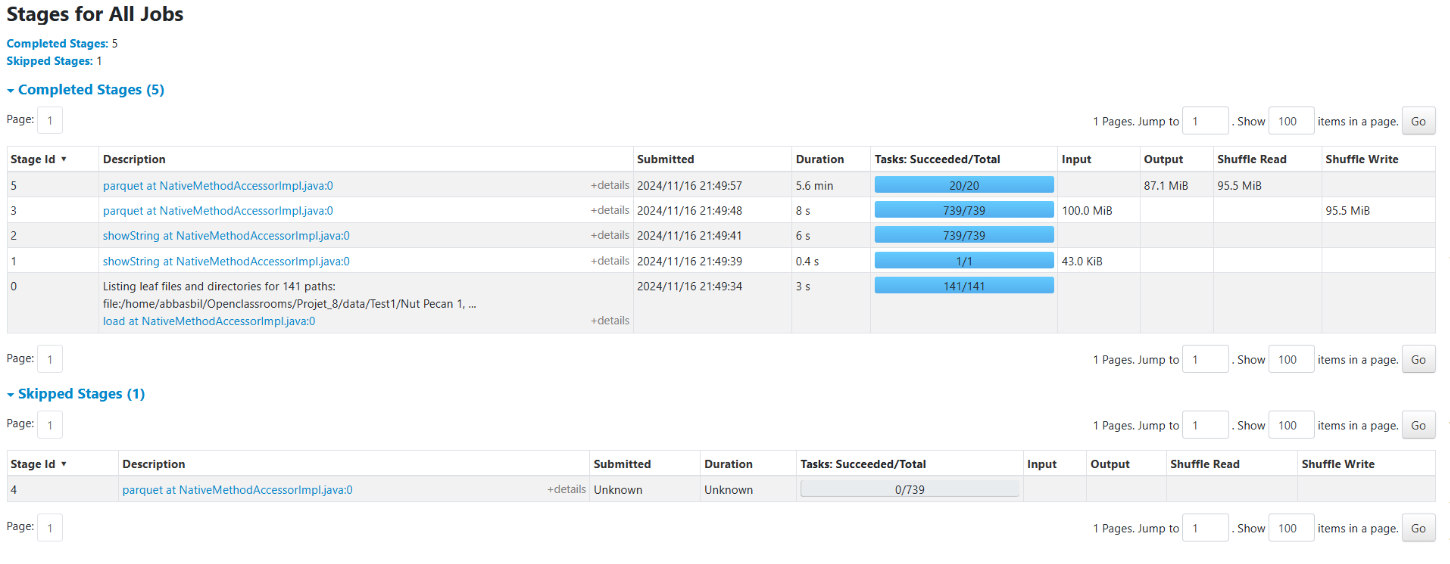

**Stage 0 :**
- **parallelize** : Création d'un RDD à partir des données initiales.  
- **mapPartitions** : Application d'une transformation sur chaque partition des données.  


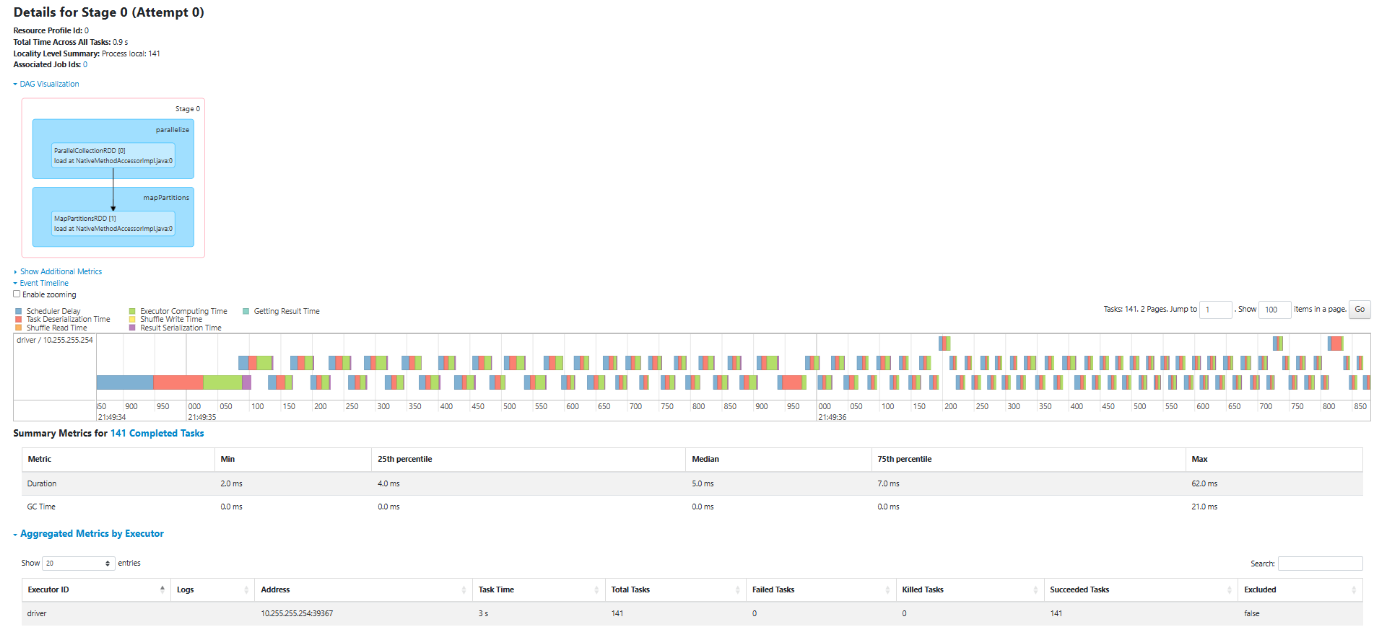

**Stage 1 :**
- **Scan binaryFile** : Lecture des fichiers binaires (images) à partir de leur chemin spécifié.  
- **WholeStageCodeGen** : Optimisation par Spark pour générer un code plus performant pour les transformations.
- **mapPartitionsInternal** : Application d'une transformation sur chaque partition pour effectuer le traitement nécessaire des données.  


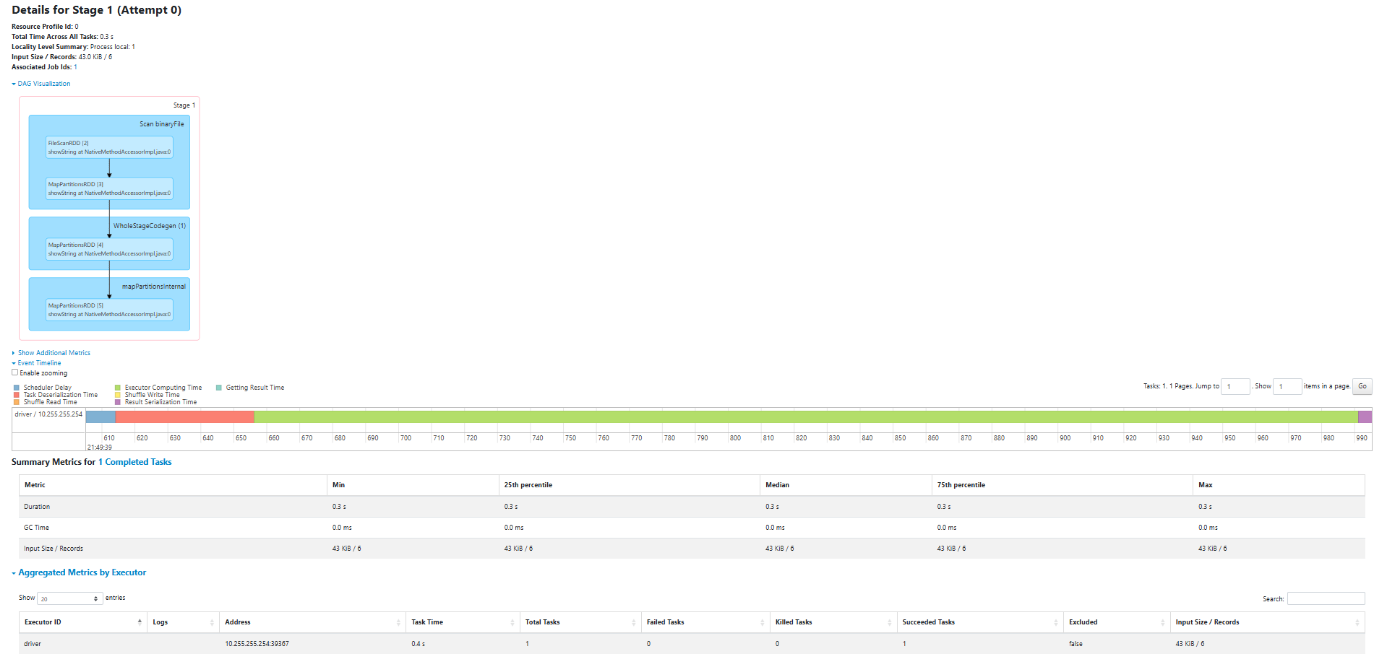


**Stage 2 :**

- **Scan binaryFile** : Lecture des fichiers binaires (images) depuis leur chemin défini.  
- **WholeStageCodeGen** : Spark génère un code optimisé pour exécuter les transformations de manière plus performante.  
- **TakeOrderedAndProject** : Sélection des données et application des filtres ou transformations spécifiques, projetées dans un ordre défini.  

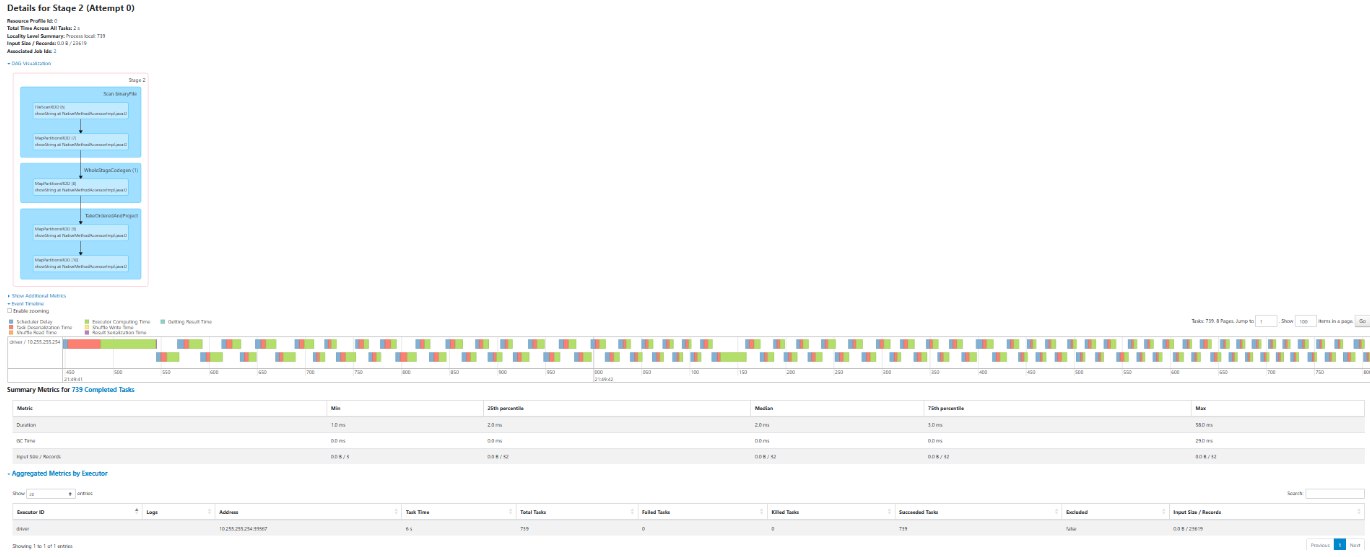

 **Stage 3 :**
- **Scan binaryFile** : Lecture des fichiers binaires (images) depuis leur chemin défini.   
- **WholeStageCodeGen** : Optimisation automatique par Spark pour améliorer les performances des transformations appliquées.  
- **Exchange** : Répartition des données entre les partitions pour des transformations nécessitant des jointures ou des regroupements.  

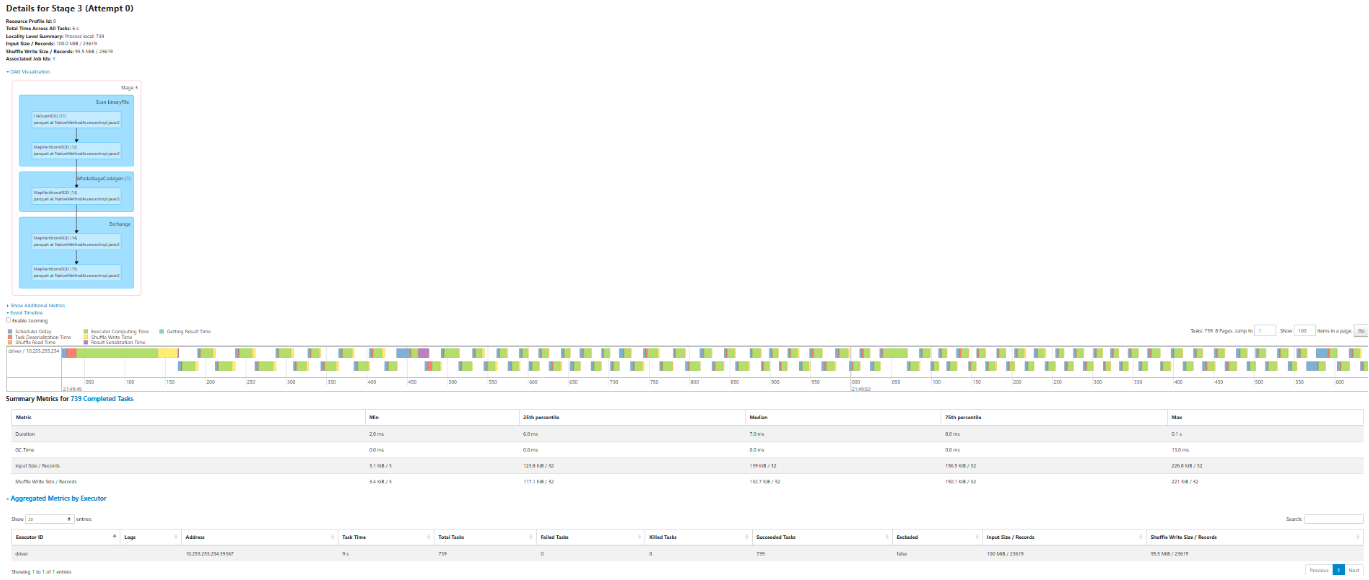

**Stage 4 :**
- **Ce stage a été skippé.**  
- Cela signifie que Spark a déterminé que les transformations ou calculs associés à ce stage n'étaient pas nécessaires pour le résultat final.  

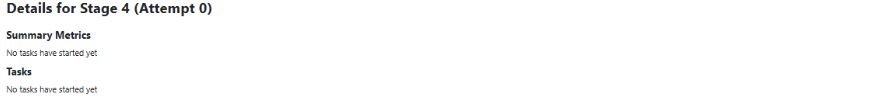

**Stage 5 :**
- **Exchange** : Redistribution des données entre les partitions, nécessaire pour des regroupements ou transformations spécifiques.  
- **ArrowEvalPython** : Utilisation de la bibliothèque **Arrow** pour optimiser les transferts de données entre Spark et Python lors des UDF (User-Defined Functions).  
- **WholeStageCodeGen** : Optimisation générée par Spark pour exécuter les transformations de manière plus performante.  
- **WriteFiles** : Écriture des résultats finaux dans les fichiers ou l'emplacement défini.  

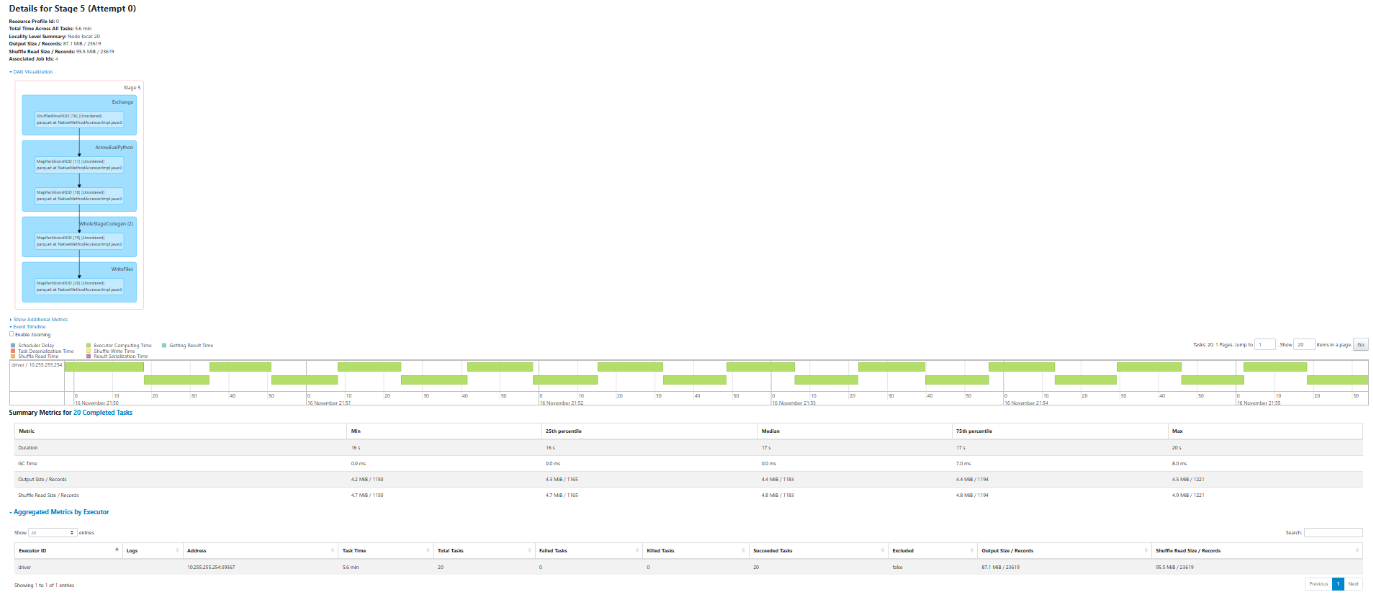

### **Chargement des données enregistrées et validation des résultats :**

On charge les fichiers Parquet dans un DataFrame **Pandas** en utilisant **PyArrow** comme moteur :  

In [22]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

On affiche le DataFrame:

In [23]:
df

,path,label,features
0,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Watermelon 1,"[0.029508105, 0.06816327, 0.0, 0.01622711, 0.5..."
1,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Watermelon 1,"[0.6506625, 0.23024622, 0.0, 0.050948307, 0.87..."
2,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Watermelon 1,"[1.2087474, 0.003020452, 0.0, 0.0, 0.8266769, ..."
3,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Pineapple Mini 1,"[0.0, 4.587646, 0.0, 0.0, 0.0, 0.0, 0.18190812..."
4,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Pineapple Mini 1,"[0.0, 4.670318, 0.0, 0.0, 0.0, 0.0, 0.12447798..."
...,...,...,...
23614,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Zucchini 1,"[0.0, 0.0, 0.0, 0.0, 0.0701553, 0.008364327, 0..."
23615,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Zucchini 1,"[0.0, 0.0, 0.0, 0.0, 0.63253796, 0.51562834, 0..."
23616,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Zucchini 1,"[0.0, 0.0, 0.0, 0.0, 0.053528484, 0.6133894, 1..."
23617,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Eggplant long 1,"[0.32061675, 0.0011167137, 0.059500773, 0.0, 0..."


On vérifie les dimensions des **features** pour une ligne spécifique du DataFrame :  

In [24]:
df.loc[0, 'features'].shape

(1280,)

#### **Conclusion :**

Avec les étapes précédentes, j'ai validé le processus sur un jeu de données en local. Cependant, avant de généraliser ce processus et de le déployer sur un cluster dans le cloud, je dois appliquer une **PCA** (Analyse en Composantes Principales) pour réduire la dimensionnalité et déterminer le nombre de composantes principales expliquant **95 % de la variance**.

### **Execution de la PCA:**

In [25]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.linalg import Vectors
import pandas as pd

# Réduction des logs pour ne garder que les erreurs
spark.sparkContext.setLogLevel("ERROR")

# Étape 1 : Conversion du DataFrame Pandas en DataFrame Spark
# Conversion de la colonne 'features' en vecteurs denses compatibles avec PySpark
df['features'] = df['features'].apply(Vectors.dense)
df_spark = spark.createDataFrame(df)

# Étape 2 : Création et application d'un VectorAssembler pour préparer les données
vecAssembler = VectorAssembler(inputCols=["features"], outputCol="features_vec")
df_spark = vecAssembler.transform(df_spark)

# Étape 3 : Initialisation des paramètres pour la PCA
variances = []  # Stockage des variances expliquées pour chaque k
resultats = []  # Résultats finaux (k, variance expliquée)
total_features = len(df_spark.select("features").first()[0])  # Nombre total de features
step_size = max(1, int(total_features * 0.01))  # 1 % des features minimum (au moins 1)

# Étape 4 : Boucle pour calculer les variances expliquées pour différentes valeurs de k
for k in range(1, total_features + 1, step_size):
    # Initialisation du modèle PCA
    pca = PCA(k=k, inputCol="features_vec", outputCol="pcaFeatures")
    
    # Entraînement du modèle
    model = pca.fit(df_spark)
    
    # Calcul de la variance expliquée cumulée
    explained_variance = float(sum(model.explainedVariance))
    variances.append(explained_variance)
    
    # Ajout des résultats pour suivi
    resultats.append((k, explained_variance))
    
    # Arrêt anticipé si la variance expliquée dépasse 80 %
    if explained_variance >= 0.8:
        break

# Ajout final : Toutes les composantes expliquent 100 % de la variance
resultats.append((total_features, 1.0))

# Affichage des résultats
for k, variance in resultats:
    print(f"Nombre de composantes : {k}, Variance expliquée : {variance:.2%}")


Nombre de composantes : 1, Variance expliquée : 9.89%
Nombre de composantes : 13, Variance expliquée : 49.03%
Nombre de composantes : 25, Variance expliquée : 61.15%
Nombre de composantes : 37, Variance expliquée : 67.91%
Nombre de composantes : 49, Variance expliquée : 72.43%
Nombre de composantes : 61, Variance expliquée : 75.81%
Nombre de composantes : 73, Variance expliquée : 78.45%
Nombre de composantes : 85, Variance expliquée : 80.56%
Nombre de composantes : 1280, Variance expliquée : 100.00%


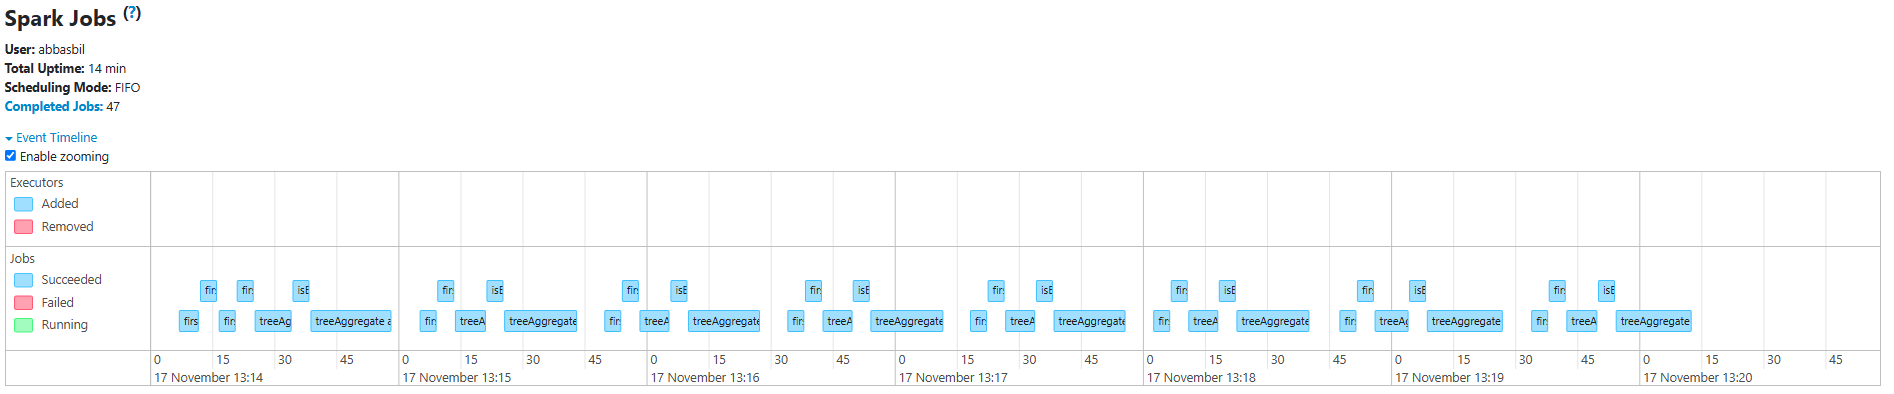

#### **Analyse des 42 stages exécutés :**

#### **1. Stages initiaux :**
- **Stage 6 :** `first at VectorAssembler.scala`  
   - Étape initiale liée à la transformation des données avec le **VectorAssembler**.  
- **Stage 7 :** `first at /tmp/ipykernel_7747/3629274763.py`  
   - Étape correspondant à l'exécution de la cellule ou du script Python.  


#### **2. Boucles récurrentes :**
- **40 stages récurrents**, répartis sur **5 boucles**, chacune contenant les **5 mêmes types de stages récurrents** :  
  1. **`first at PCA.scala`** : Étape principale où la réduction de dimension est appliquée à chaque itération avec la PCA.  
  2. **`first at RowMatrix.scala`** : Initialisation et manipulation des matrices de lignes pour les calculs PCA.  
  3. **`treeAggregate at Statistics.scala`** : Calcul agrégé des statistiques nécessaires.  
  4. **`isEmpty at RowMatrix.scala`** : Vérification de l'existence ou de l'état des données.  
  5. **`treeAggregate at RowMatrix.scala`** : Nouvelle agrégation appliquée sur les matrices pour les calculs statistiques.  

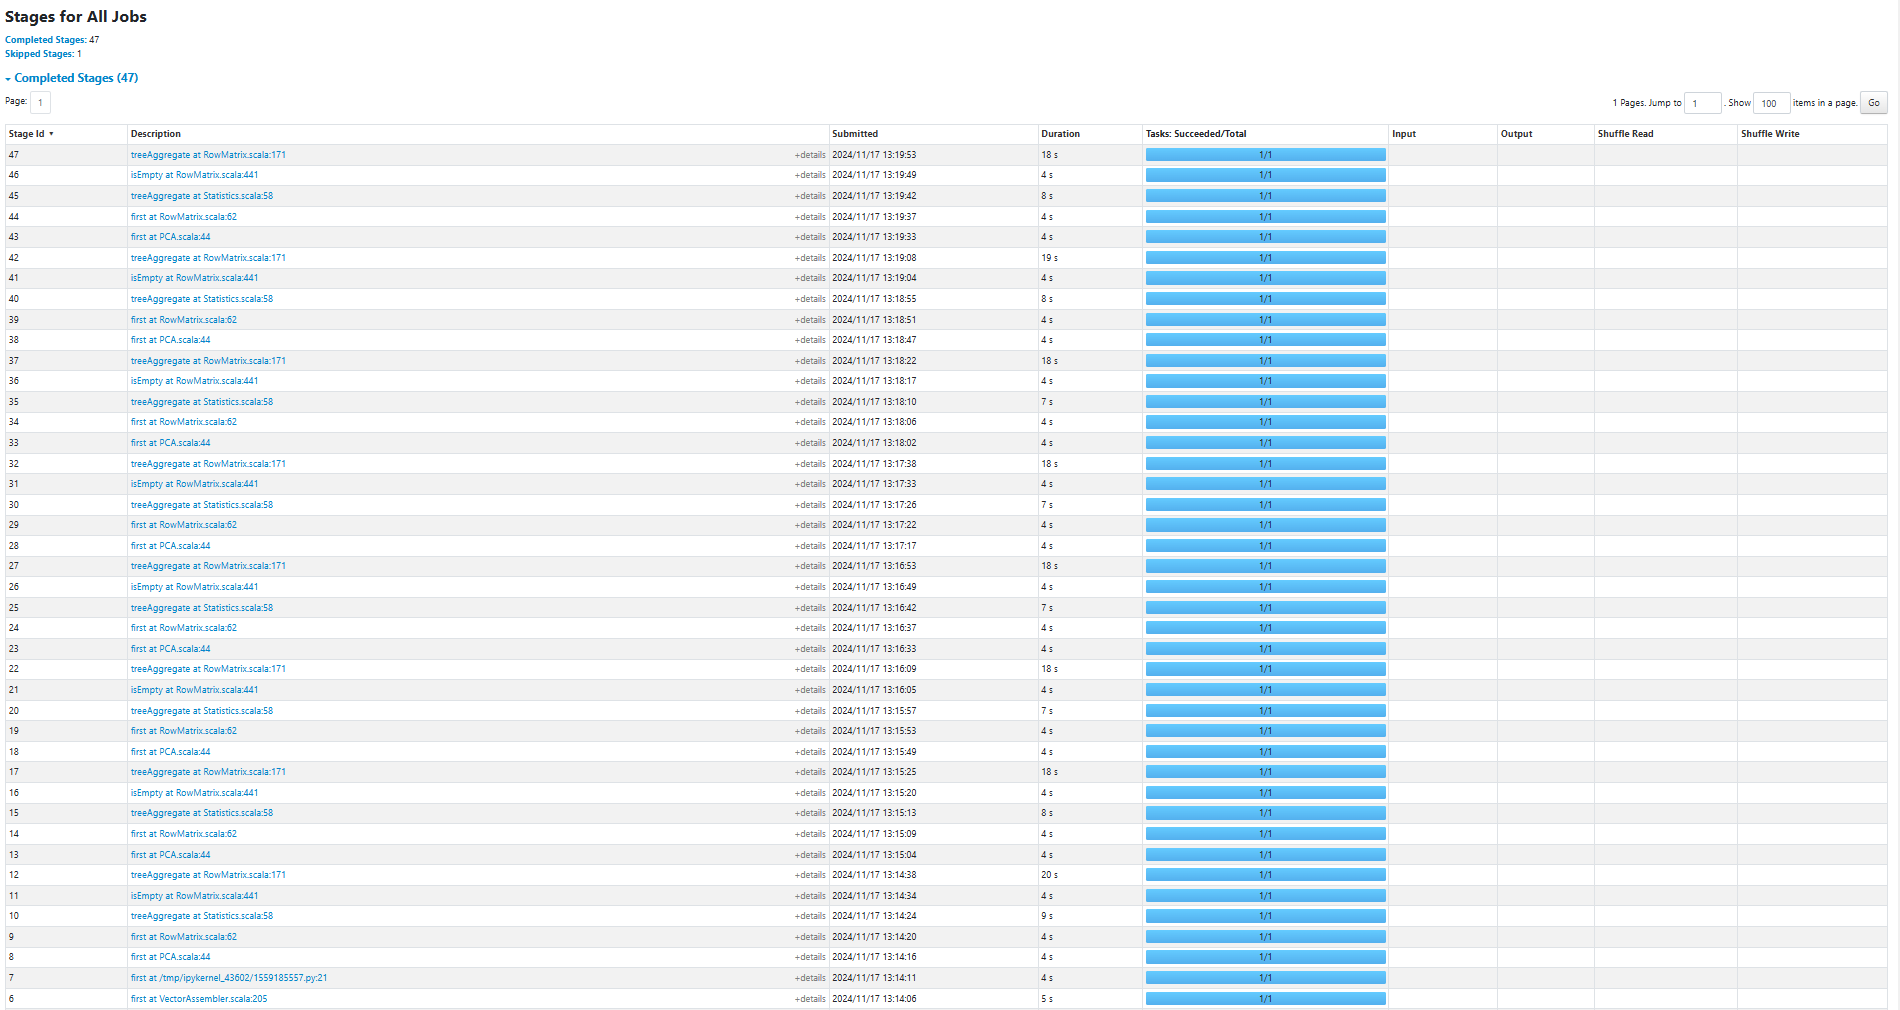

Voici un exemple des 5 stages récurrents:

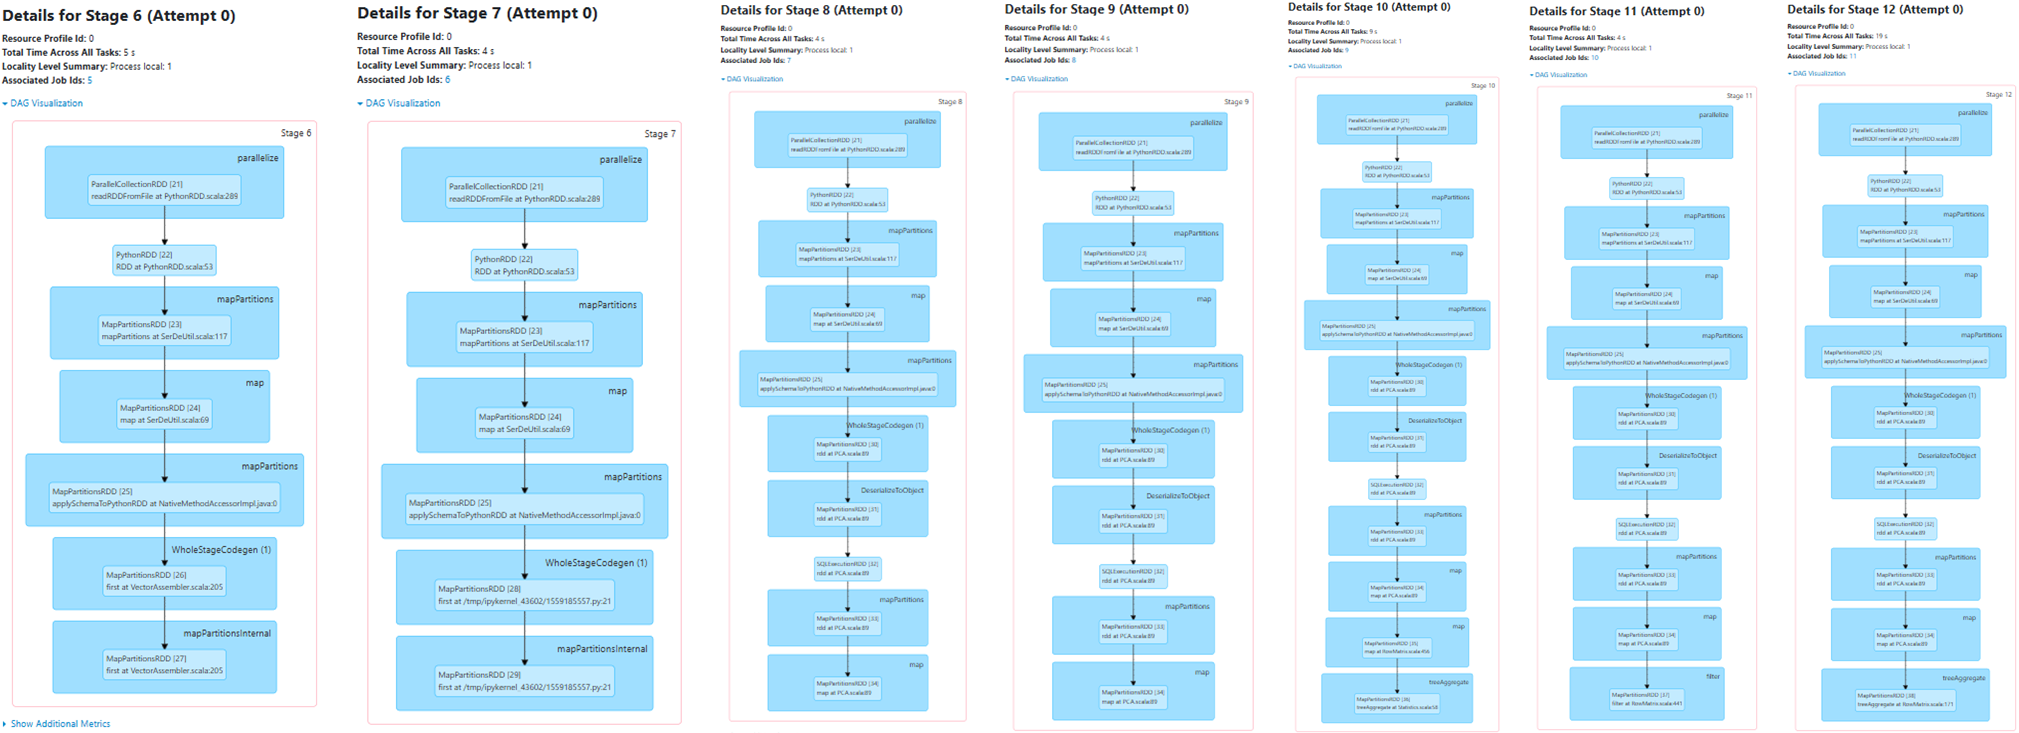

#### **Visualisation de l'explication de la variance en fonction du nombre de composantes principales**

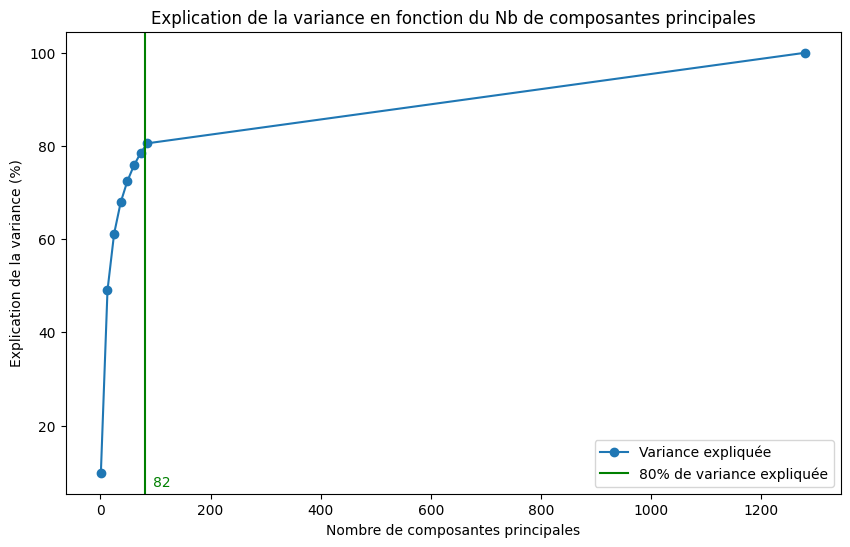

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Étape 1 : Préparer les données pour le graphe
# x_data contient le nombre de composantes principales
# y_data contient la variance expliquée en pourcentage (multipliée par 100 pour passer de fraction à %)
x_data = [i[0] for i in resultats]
y_data = [i[1] * 100 for i in resultats]

# Étape 2 : Créer un graphique
plt.figure(figsize=(10, 6))  # Taille du graphique
plt.plot(x_data, y_data, marker='o', label='Variance expliquée')  # Ligne avec marqueurs pour chaque point

# Étape 3 : Ajouter des titres et des labels
plt.title('Explication de la variance en fonction du Nb de composantes principales')  # Titre du graphique
plt.xlabel('Nombre de composantes principales')  # Label de l'axe x
plt.ylabel('Explication de la variance (%)')  # Label de l'axe y

# Étape 4 : Identifier le point correspondant à 80% de variance expliquée
x_80 = np.interp(80, y_data, np.round(x_data))  # Interpolation pour trouver la valeur de x correspondant à y=80

# Étape 5 : Ajouter une ligne verticale au point x_80
plt.axvline(x=x_80, color='g', label='80% de variance expliquée')  # Ligne verticale verte

# Étape 6 : Ajouter une annotation pour x_80
plt.text(x_80 + 30, 7, f'{math.ceil(x_80)}', color='g', ha='center')  # Texte indiquant la valeur de x

# Étape 7 : Ajouter une légende
plt.legend()  # Affiche la légende du graphique

# Étape 8 : Afficher le graphique
plt.show()


**Résultat :**

In [27]:
Nb_composants_80 = math.ceil(x_80)
print(f"Le nombre de composantes principales nécessaires pour expliquer 80 % de la variance : {Nb_composants_80}")

Le nombre de composantes principales nécessaires pour expliquer 80 % de la variance : 82


### **Application de la PCA pour conserver un nombre de composantes expliquant 80 % de la variance:**

In [28]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Réduction des logs à l'essentiel
spark.sparkContext.setLogLevel("ERROR")

# Étape 1 : Conversion du DataFrame Pandas en DataFrame PySpark
# Transformation de la colonne 'features' en vecteurs denses pour compatibilité avec Spark
df['features'] = df['features'].apply(lambda x: Vectors.dense(x))
df_spark = spark.createDataFrame(df)

# Étape 2 : Création et application d'un VectorAssembler
# Combine les colonnes en une seule colonne vectorielle pour le modèle PCA
vecAssembler = VectorAssembler(inputCols=["features"], outputCol="features_vec")
df_spark = vecAssembler.transform(df_spark)

# Étape 3 : Création et entraînement d'un modèle PCA
# Utilisation du nombre de composantes principales correspondant à 80 % de la variance
print(f"Le nombre de composantes principales nécessaires pour expliquer 80 % de la variance : {Nb_composants_80}")
pca = PCA(k=Nb_composants_80, inputCol="features_vec", outputCol="pcaFeatures")
model = pca.fit(df_spark)

# Étape 4 : Transformation des données avec le modèle PCA
result = model.transform(df_spark)

# Étape 5 : Nettoyage des colonnes inutiles
# Suppression de la colonne intermédiaire 'features_vec' pour simplifier le DataFrame
result = result.drop('features_vec')

# Étape 6 : Affichage des résultats
result.show()


Le nombre de composantes principales nécessaires pour expliquer 80 % de la variance : 82


+--------------------+----------------+--------------------+--------------------+
|                path|           label|            features|         pcaFeatures|
+--------------------+----------------+--------------------+--------------------+
|file:/home/abbasb...|    Watermelon 1|[0.02950810454785...|[-2.4482855271473...|
|file:/home/abbasb...|    Watermelon 1|[0.65066248178482...|[-4.1068527673911...|
|file:/home/abbasb...|    Watermelon 1|[1.20874738693237...|[-2.9759471838941...|
|file:/home/abbasb...|Pineapple Mini 1|[0.0,4.5876460075...|[-4.6210754558349...|
|file:/home/abbasb...|Pineapple Mini 1|[0.0,4.6703181266...|[-5.9413218480235...|
|file:/home/abbasb...|    Watermelon 1|[0.77536010742187...|[-3.1441707637246...|
|file:/home/abbasb...|Pineapple Mini 1|[0.0,4.5827326774...|[-4.6034014342370...|
|file:/home/abbasb...|Pineapple Mini 1|[0.0,4.9428706169...|[-5.6624251560056...|
|file:/home/abbasb...|    Watermelon 1|[0.0,0.2040265202...|[-2.5743435166751...|
|file:/home/abba

#### **Définition d'un nouveau chemin pour enregistrer les features PCA :**

In [29]:
# Création d'un nouveau chemin pour stocker les résultats de la PCA
PATH = os.getcwd()  # Obtenir le chemin du répertoire de travail actuel
PATH_Data = os.path.join(PATH, 'data', 'Test1')  # Chemin vers les données initiales
PATH_Result_PCA = os.path.join(PATH, 'data', 'Results_PCA')  # Chemin pour enregistrer les résultats de la PCA

# Affichage des chemins définis
print('PATH:        ' + PATH + 
      '\nPATH_Data:   ' + PATH_Data + 
      '\nPATH_Results_PCA: ' + PATH_Result_PCA)

PATH:        /home/abbasbil/Openclassrooms/Projet_8
PATH_Data:   /home/abbasbil/Openclassrooms/Projet_8/data/Test1
PATH_Results_PCA: /home/abbasbil/Openclassrooms/Projet_8/data/Results_PCA


#### **Enregistrement des résultats après PCA au format Parquet :**

In [30]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT, DenseVector
from pyspark.sql.types import ArrayType, FloatType

# Étape 1 : Définir une UDF pour convertir les vecteurs en listes
# Cette UDF permet de convertir un objet DenseVector en une liste Python
vector_to_list = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

# Étape 2 : Appliquer la conversion sur les colonnes contenant des vecteurs
# Convertir la colonne 'features' en une liste de nombres
result = result.withColumn("features", vector_to_list(result["features"]))
# Convertir la colonne 'pcaFeatures' en une liste de nombres
result = result.withColumn("pcaFeatures", vector_to_list(result["pcaFeatures"]))

# Étape 3 : Enregistrer les résultats au format Parquet
# Mode 'overwrite' permet de réécrire les fichiers si un dossier existant est trouvé
result.write.mode('overwrite').parquet(PATH_Result_PCA)

In [31]:
df = pd.read_parquet(PATH_Result_PCA, engine='pyarrow')

In [32]:
df

,path,label,features,pcaFeatures
0,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Watermelon 1,"[0.029508105, 0.06816327, 0.0, 0.01622711, 0.5...","[-2.4482856, 5.4137383, -7.03708, -2.881991, 8..."
1,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Watermelon 1,"[0.6506625, 0.23024622, 0.0, 0.050948307, 0.87...","[-4.1068525, 5.1684656, -6.825175, -4.649991, ..."
2,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Watermelon 1,"[1.2087474, 0.003020452, 0.0, 0.0, 0.8266769, ...","[-2.9759471, 3.5011277, -6.7286835, -3.5014265..."
3,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Pineapple Mini 1,"[0.0, 4.587646, 0.0, 0.0, 0.0, 0.0, 0.18190812...","[-4.6210756, 1.7874815, 0.25306198, -3.9269176..."
4,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Pineapple Mini 1,"[0.0, 4.670318, 0.0, 0.0, 0.0, 0.0, 0.12447798...","[-5.941322, 2.9444354, -0.2409493, -4.521189, ..."
...,...,...,...,...
23614,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Zucchini 1,"[0.0, 0.0, 0.0, 0.0, 0.0701553, 0.008364327, 0...","[-2.2596345, 2.1426723, 2.8969903, 1.1718857, ..."
23615,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Zucchini 1,"[0.0, 0.0, 0.0, 0.0, 0.63253796, 0.51562834, 0...","[-2.534249, 2.4426167, 3.3674803, 0.9579889, 7..."
23616,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Zucchini 1,"[0.0, 0.0, 0.0, 0.0, 0.053528484, 0.6133894, 1...","[-2.3596263, 2.1614966, 2.5853395, 0.4265223, ..."
23617,file:/home/abbasbil/Openclassrooms/Projet_8/da...,Eggplant long 1,"[0.32061675, 0.0011167137, 0.059500773, 0.0, 0...","[-3.0267527, 4.8349757, 3.096181, -1.3138245, ..."


#### Conclusion

Le processus de PCA a été appliqué avec succès, réduisant les vecteurs de caractéristiques pour capturer **80 %** de la variance. Le DataFrame final contient **23,619 lignes** avec les colonnes :  
- **`path`** : Chemin des images.  
- **`label`** : Classe des images.  
- **`features`** : Caractéristiques initiales.  
- **`pcaFeatures`** : Caractéristiques réduites.

Les résultats sont prêts pour une analyse ou un modèle de classification.

In [1]:
import pandas as pd

# Creating a structured format for the CNIL registry as an Excel file
data = {
    "Section": [
        "Description du traitement",
        "Nom du traitement",
        "N° / RÉF",
        "Date de création du traitement",
        "Mise à jour du traitement",
        "Acteurs",
        "Responsable du traitement",
        "Délégué à la protection des données",
        "Société du DPO (si celui-ci est externe)",
        "Représentant",
        "Responsable(s) conjoint(s)",
        "Finalité(s) du traitement effectué",
        "Finalité principale",
        "Sous-finalité 1",
        "Sous-finalité 2",
        "Sous-finalité 3",
        "Sous-finalité 4",
        "Sous-finalité 5",
        "Catégories de données personnelles concernées",
        "État civil, identité, données d'identification, images…",
        "Vie personnelle (habitudes de vie, situation familiale, etc.)",
        "Informations d'ordre économique et financier (revenus, situation financière, situation fiscale, etc.)",
        "Données de connexion (adresse IP, logs, etc.)",
        "Données de localisation (déplacements, données GPS, GSM, etc.)",
        "Numéro de Sécurité Sociale (ou NIR)",
        "Données sensibles",
        "Données révélant l'origine raciale ou ethnique",
        "Données révélant les opinions politiques",
        "Données révélant les convictions religieuses ou philosophiques",
        "Données révélant l'appartenance syndicale",
        "Données génétiques",
        "Données biométriques aux fins d'identifier une personne physique de manière unique",
        "Données concernant la santé",
        "Données concernant la vie sexuelle ou l'orientation sexuelle",
        "Données relatives à des condamnations pénales ou infractions",
        "Catégories de personnes concernées",
        "Catégorie de personnes 1",
        "Catégorie de personnes 2",
        "Destinataires",
        "Destinataire 1",
        "Destinataire 2",
        "Destinataire 3",
        "Destinataire 4",
        "Mesures de sécurité",
        "Mesure de sécurité 1",
        "Mesure de sécurité 2",
        "Mesure de sécurité 3",
        "Transferts hors UE",
        "Organisme destinataire 1",
        "Organisme destinataire 2",
        "Organisme destinataire 3",
        "Organisme destinataire 4",
    ],
    "Valeur": [None] * 51
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to an Excel file
file_path = "CNIL_Register_Template.xlsx"
df.to_excel(file_path, index=False, sheet_name="Registre CNIL")

file_path


ValueError: All arrays must be of the same length